# Imports

In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

from scipy import stats 

from sklearn.neighbors import (NearestNeighbors, 
                               KNeighborsRegressor)

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.experimental import enable_halving_search_cv 

from sklearn.model_selection import (train_test_split, 
                                     learning_curve,
                                     cross_val_score,
                                     RandomizedSearchCV,
                                     GridSearchCV,
                                     HalvingGridSearchCV)

from sklearn.tree import (DecisionTreeRegressor, 
                          ExtraTreeRegressor)

from sklearn.ensemble import (RandomForestRegressor, 
                              IsolationForest)

from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import (SelectKBest, 
                                       f_regression)

from sklearn.preprocessing import (MinMaxScaler, 
                                   RobustScaler, 
                                   StandardScaler, 
                                   MaxAbsScaler,
                                   FunctionTransformer,
                                   OneHotEncoder,
                                   PolynomialFeatures,
                                   OrdinalEncoder) 

from sklearn.metrics import (r2_score,
                             mean_squared_error, 
                             mean_absolute_error,
                             SCORERS)

from matplotlib import pyplot as plt
import seaborn as sns

from eli5.sklearn import PermutationImportance
import eli5

In [2]:
warnings.filterwarnings('ignore') 

In [3]:
sns.set_style('darkgrid')

In [4]:
df = pd.read_csv('kc_house_data.csv')

In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Feature Engineering

## Ajustes dos tipos de dados

In [338]:
#df.drop('id', axis = 1, inplace = True)
df.date = pd.to_datetime(df.date)
df.bedrooms = df.bedrooms.astype('category')
df.bathrooms = df.bathrooms.astype('category')
df.floors = df.floors.astype('float')

df.waterfront = df.waterfront.astype('bool')
df.condition = df.condition.astype('category')
df.grade = df.grade.astype('category')
df.view = df.view.astype('category')
df.zipcode = df.zipcode.astype('object')

# df.yr_renovated = df.yr_renovated.replace(0, np.nan)
# df.yr_renovated = pd.to_datetime(df.yr_renovated, format = '%Y').dt.year

## Criação de features

In [8]:
### Feature Engineering ###

df['month'] = df.date.dt.month
df['bedbath']    = df.apply(lambda x: x.bedrooms/x.bathrooms if x.bathrooms > 0 else x.bedrooms, axis = 1)
df['renovated']  = df.yr_renovated.apply(lambda x: 1 if x>0 else 0)
df['flr_living'] = df.floors*df.sqft_living
df['livinglot']  = df.sqft_living/df.sqft_lot
df['lastbuild']  = df.apply(lambda x: (2022 - x.yr_renovated) if x.yr_renovated > 0 else (2022 - x.yr_built), axis =1)

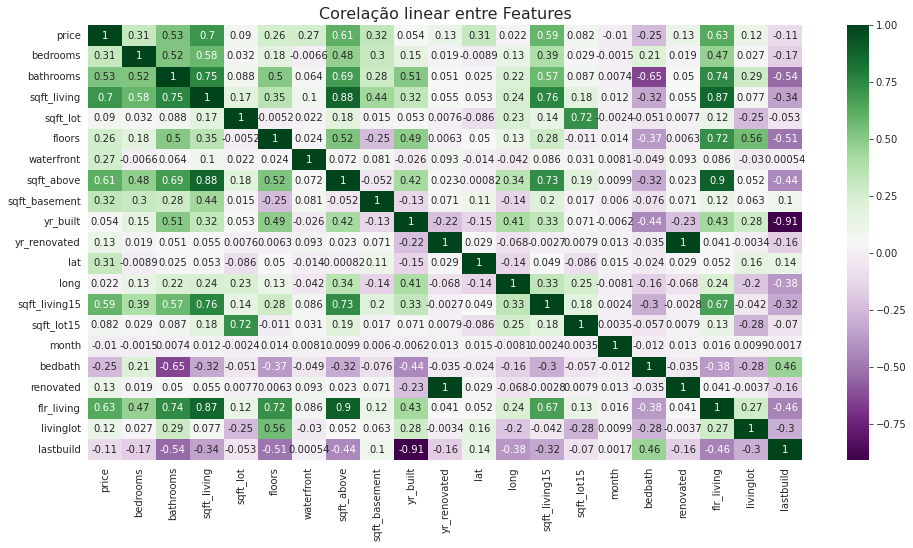

In [56]:
plt.figure(figsize = (16,8))
sns.heatmap(df.drop('id', axis = 1).corr(), annot = True, cmap = 'PRGn')
plt.title("Corelação linear entre Features", fontsize = 16)
plt.show()

# Data Preparation

In [10]:
df1 = df.copy()

In [258]:
X = df.drop(['zipcode','price','date', 'yr_renovated','yr_built', 'id','long'], axis = 1)
y = df.price

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle = True)

## Feature Selection

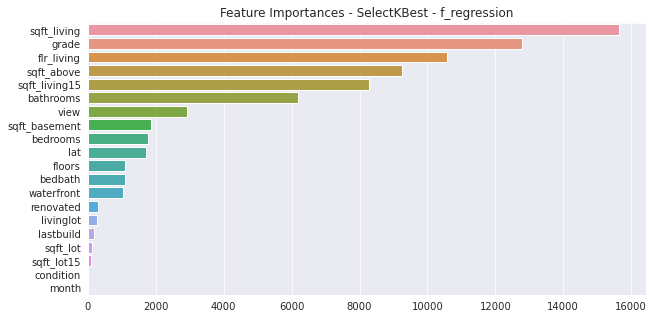

array(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'lat', 'sqft_living15', 'sqft_lot15', 'month',
       'bedbath', 'renovated', 'flr_living', 'livinglot', 'lastbuild'],
      dtype=object)

In [341]:
skbest = SelectKBest(f_regression, k = 'all')
skbest.fit_transform(X_train, y_train)
s1 = pd.Series(data = skbest.scores_, index = skbest.feature_names_in_).sort_values(ascending = False)
plt.figure(figsize=(10,5))
sns.barplot(x = s1.values, y=s1.index, orient = 'h')
plt.title('Feature Importances - SelectKBest - f_regression')
plt.show()

Possíveis K valores: 7, 10, 13.

## Verificação de outliers 

In [ ]:
#Método IQR

for col in X_train.select_dtypes(include = 'number').drop(['month','lat','long', 'renovated'], axis = 1).columns:
    mean   = X_train[col].mean()
    std    = X_train[col].std()
    cutoff = 3*stats.iqr(X_train[col])
    outs   = (X_train[(X_train[col] < mean - cutoff) | (X_train[col] > mean + cutoff)]).shape[0]
    print(f'{col}: {outs}')

In [105]:
#Isolation Forest

iso_forest = IsolationForest()
outliers = iso_forest.fit_predict(X_train.drop(['month','lat','long', 'renovated'], axis =1))
print(f'Possíveis outliers: {(outliers == -1).sum()}')

Possíveis outliers: 1296


In [99]:
# Remoção de outliers por Isolation Forest
X_train_if, y_train_if = X_train[(outliers!=-1)], y_train[(outliers!=-1)]

A remoção dos possíveis outliers acabou por degradar um pouco a performance do modelo.

# Criação de Pipelines de Processamento e Modelagem

In [376]:
num_pipe = Pipeline(steps=[('log', FunctionTransformer(np.log1p)),
                           ('scaler', MinMaxScaler())
                          ])

In [377]:

def ct_mount(X_train):
    order_columns = ['condition','view']
    numeric_columns = ['sqft_living','sqft_lot','sqft_living15','sqft_lot15']

    order_columns = [col for col in order_columns if col in X_train.columns]
    numeric_columns = [col for col in numeric_columns if col in X_train.columns]

    ct = ColumnTransformer(transformers=[
        ('numeric', num_pipe, numeric_columns),
       # ('order', OrdinalEncoder(), order_columns)
        ], remainder = 'passthrough')

Adaptação do Column Transformer para ser aplicado após a seleção de features.

## Teste de Modelos Baseline

In [13]:
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

Função R² ajustado

In [363]:
mean_prediction_vector = (df.price.mean()*np.ones(y_test.shape[0]))

print(f'R2: {r2_score(y_test, mean_prediction_vector)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(y_test, mean_prediction_vector)),2)}')

R2: -0.0004121721171661541
RMSE: 386845.29


## Model Selection

In [371]:
scalers    = [StandardScaler(), RobustScaler(), MinMaxScaler()]
regressors = [LinearRegression(), RandomForestRegressor(), DecisionTreeRegressor(), ExtraTreeRegressor(), KNeighborsRegressor()]
scores     = []
for scaler in scalers:
    for regressor in regressors:
        pipe = Pipeline(steps = [('fs', SelectKBest(f_regression, k = 'all')),
                                 ('preprocessor', ct_mount(X_train)),
                                 ('modeling', regressor)])
        
        score = cross_validate(pipe, X = X_train, y = y_train, scoring = ['r2', 'neg_mean_squared_error'], cv = 5)
        #adj_score = adjustedR2(score, X_train.shape[0], X_train.shape[1])
        print(regressor, scaler, score['test_r2'].mean(), np.sqrt(-score['test_neg_mean_squared_error'].mean()))

LinearRegression() StandardScaler() 0.7057424800080649 195654.04193238658
RandomForestRegressor() StandardScaler() 0.8409888007264106 143753.2930693226
DecisionTreeRegressor() StandardScaler() 0.6613777989634265 208986.5364262938
ExtraTreeRegressor() StandardScaler() 0.6322421926168051 217910.16030144726
KNeighborsRegressor() StandardScaler() 0.505665561903171 253909.4614891573
LinearRegression() RobustScaler() 0.7057424800080649 195654.04193238658
RandomForestRegressor() RobustScaler() 0.8413430183880453 143589.20554377965
DecisionTreeRegressor() RobustScaler() 0.6596681825353178 209485.4866388058
ExtraTreeRegressor() RobustScaler() 0.658327909407965 210243.40821006394
KNeighborsRegressor() RobustScaler() 0.505665561903171 253909.4614891573
LinearRegression() MinMaxScaler() 0.7057424800080649 195654.04193238658
RandomForestRegressor() MinMaxScaler() 0.8433040796226097 142696.49030285046
DecisionTreeRegressor() MinMaxScaler() 0.6589359390725391 209820.2382811718
ExtraTreeRegressor() Mi

Melhor modelo observado: Random Forest Regressor, seguido pela Regressão Linear Simples

In [378]:
pipes = {'LinearRegression': Pipeline(steps = [('preprocessor', ct_mount(X_train)),
                                     ('poly', PolynomialFeatures(degree = 2)),
                                     ('modeling', LinearRegression())
                             ]),
         'RandomForest': Pipeline(steps = [('preprocessor', ct_mount(X_train)),
                                           ('modeling', RandomForestRegressor())
                           ])
        }

In [381]:
def model_validation(pipes):
    
    for model, pipe in pipes.items():
        start = datetime.now()
        scores = cross_validate(pipe, X=X_train, y=y_train, scoring = ['r2','neg_mean_squared_error'], cv=5)
        score = adjustedR2(scores['test_r2'].mean(), X_train.shape[0], X_train.shape[1])
        end = datetime.now()
        print(model)
        print('Time: ',end-start)
        print('Test_R2:  ', score, scores['test_r2'].std())
        print('Test_MSE:  ', np.sqrt(-scores['test_neg_mean_squared_error'].mean()), np.sqrt(scores['test_neg_mean_squared_error'].std()))
        print()
        
model_validation(pipes)

LinearRegression
Time:  0:00:01.156564
Test_R2:   0.7898016719619798 0.017647569451490108
Test_MSE:   164557.0242228354 42388.78445287272

RandomForest
Time:  0:00:59.617952
Test_R2:   0.8426738103942195 0.007412381377139709
Test_MSE:   142906.4626660633 50354.730722521876



In [389]:
reglin_pipe = pipes['LinearRegression']
rf_pipe = pipes['RandomForest']

In [442]:
def lcurves(pipe):

        lc = learning_curve(pipe, X_train, y_train, cv = 5, shuffle = True, scoring = 'r2')
        plt.figure(figsize=(7,4))
        sns.lineplot(x=lc[0], y=np.mean(lc[1], axis = 1), label = 'train', marker = "X")
        sns.lineplot(x=lc[0], y=np.mean(lc[2], axis = 1), label = 'validation', marker = 'X')
        plt.title(f'Learning Curves - {model}', fontsize = 12)
        plt.legend()
        
lcurves(rf_pipe)

TypeError: estimator should be an estimator implementing 'fit' method, {'LinearRegression': Pipeline(steps=[('preprocessor', None), ('poly', PolynomialFeatures()),
                ('modeling', LinearRegression())]), 'RandomForest': Pipeline(steps=[('preprocessor', None), ('modeling', RandomForestRegressor())])} was passed

A diferença entre o score de treino e validação revela um indício de overfitting no modelo Random Forest.

O mesmo não ocorre no modelo de Regressão Linear. Como esse modelo parece não ter muito overfitting, não há necessidade de testar versão com regularização para melhorar as métricas (Lasso, Ridge, ElasticNet).

Há possibilidade de melhorar o modelo Random Forest reduzindo o overfitting com tunagem de hiperparâmetros

# Tunagem de Hiperparâmetros

In [399]:
rf_pipe.named_steps['modeling'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [434]:
grid = {'modeling__max_depth':[20, 25,30, None],
        'modeling__max_features':['auto',3,5,10,15],
        'modeling__min_samples_split':[2,5,10],
        'modeling__n_estimators':[100,300,600],
        'modeling__min_samples_leaf':[1,2,3,4,5]
        }

In [438]:
def hgridsearch(scoring = 'r2'):
    gsearch = HalvingGridSearchCV(rf_pipe, grid, cv = 5, scoring = scoring)
    gsearch.fit(X=X_train, y = y_train)
    return gsearch.best_params_, gsearch.best_score_

In [439]:
grid_result = hgridsearch()

In [440]:
grid_result[0]

{'modeling__max_depth': 20,
 'modeling__max_features': 15,
 'modeling__min_samples_leaf': 1,
 'modeling__min_samples_split': 2,
 'modeling__n_estimators': 600}

In [441]:
grid_result[1]

0.8441581042745987

# Testagem final do Modelo

In [444]:
rf_pipe = Pipeline(steps = [('preprocessor', ct_mount(X_train)),
                            ('modeling', RandomForestRegressor(max_depth= 20,
                                                             max_features= 15,
                                                             min_samples_leaf= 1,
                                                             min_samples_split= 2,
                                                             n_estimators= 600))
                                                                                       ])

In [445]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', None),
                ('modeling',
                 RandomForestRegressor(max_depth=20, max_features=15,
                                       n_estimators=600))])

In [ ]:
lcurves(rf_pipe)

In [422]:
pred = rf_pipe.predict(X_test)
r2_score(y_test, pred)
np.sqrt(mean_squared_error(y_test, pred))

166340.8125714345

# Feature Importances

### Permutation Importance

In [424]:
perm = PermutationImportance(rf_pipe)

In [425]:
perm.fit(X_test, y_test)

PermutationImportance(estimator=Pipeline(steps=[('preprocessor', None),
                                                ('modeling',
                                                 RandomForestRegressor(max_features=10,
                                                                       min_samples_split=5))]))

In [426]:
p_imp = pd.Series(perm.feature_importances_, index = X_test.columns)
p_imp.sort_values(ascending = False, inplace = True)

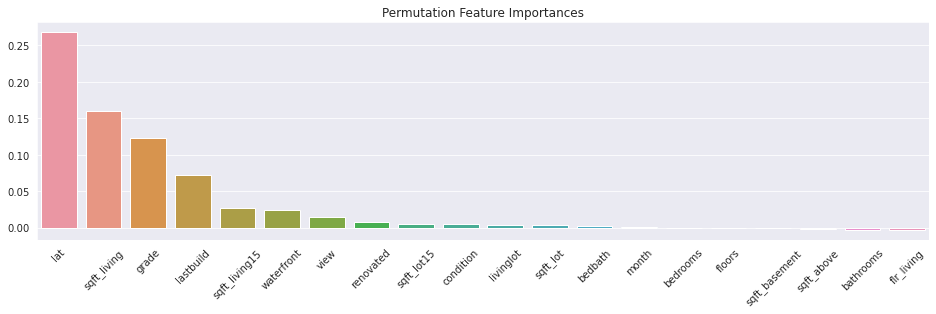

In [427]:
plt.figure(figsize=(16,4))
sns.barplot(x=p_imp.index, y= p_imp.values)
plt.xticks(rotation = 45)
plt.title('Permutation Feature Importances')
plt.show()

In [276]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.3666 ± 0.0288,lat
0.2691 ± 0.0218,sqft_living
0.2046 ± 0.0294,long
0.1553 ± 0.0184,grade
0.0340 ± 0.0039,waterfront
0.0243 ± 0.0039,sqft_living15
0.0079 ± 0.0027,lastbuild
0.0068 ± 0.0009,sqft_above
0.0064 ± 0.0010,view
0.0055 ± 0.0009,sqft_lot15


### Random Forest Feature Importances

In [267]:
fi_indices = pipe.named_steps['modeling'].feature_importances_.argsort()

In [273]:
pipe.named_steps['modeling'].feature_importances_

array([0.25471655, 0.0105224 , 0.00084258, 0.02960742, 0.01245843,
       0.00195908, 0.01281635, 0.03344442, 0.01071653, 0.00277398,
       0.33013805, 0.0176076 , 0.0061019 , 0.16219852, 0.0703766 ,
       0.0060027 , 0.00570224, 0.00178477, 0.00957178, 0.0070727 ,
       0.01358539])

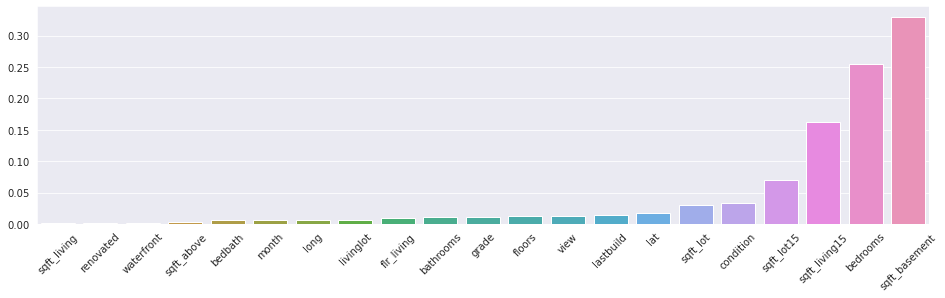

In [272]:
plt.figure(figsize=(16,4))
sns.barplot(x=X_train.columns[fi_indices], y=pipe.named_steps['modeling'].feature_importances_[fi_indices])
plt.xticks(rotation = 45)
plt.show()